# ETL Pipeline for Multi-Asset Portfolio Analysis

## Project Overview and Goals

This project develops an example simplified ETL pipeline to transform raw financial market data into actionable investment insights. We perform data extraction and some ETL to display data engineering capabilities for financial analytics, from extraction through validation to practical portfolio applications.

**Primary Goal**: Build a production-ready ETL pipeline that processes multi-asset financial data with institutional-grade quality standards, enabling sophisticated portfolio analytics and risk management.

## Stakeholders and Use Cases

**Target Stakeholders**:
- **Portfolio Managers**: Require clean, aligned data for daily performance tracking and strategic allocation decisions
- **Risk Management Teams**: Need validated cross-asset data for correlation analysis and risk assessment
- **Quantitative Analysts**: Depend on high-quality historical data for backtesting and model development
- **Data Engineering Teams**: Seek best practices for financial data pipelines and quality validation frameworks

**Business Value**: This pipeline eliminates manual data cleaning, reduces analytical errors by ensuring 100% temporal alignment, and enables real-time portfolio analytics that would be impossible with fragmented or low-quality data sources.

## Data Source and Setup

**Why Yahoo Finance?**: It's free, has lots of historical data, and works well for learning projects. For real business use, you'd probably use professional data providers like Bloomberg, but Yahoo Finance is perfect for homework.

**Challenge**: Yahoo Finance can be a bit unreliable since it's not an official API - sometimes it blocks requests or changes how it works. We need to be careful not to make too many requests too quickly.

**My approach**: I'll set up a custom session with proper headers and retry logic to make the data downloads more reliable. This shows good programming practices for working with web APIs.

In [19]:
# General basic imports for the analysis
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import time
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Configure yfinance with custom session and headers
def setup_yfinance_session():
    """Set up a robust session for yfinance with headers and retry logic."""
    session = requests.Session()
    
    # Custom headers to avoid detection
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'DNT': '1',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1',
    }
    session.headers.update(headers)
    
    # Retry strategy
    retry_strategy = Retry(
        total=3,
        status_forcelist=[429, 500, 502, 503, 504],
        backoff_factor=1
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    
    return session

# Apply the session globally to yfinance
custom_session = setup_yfinance_session()
yf._get_data_session = lambda: custom_session

print("Custom yfinance session configured!")

Custom yfinance session configured!


Let's test this solution by looking up a stock. The [Lookup API](https://yfinance-python.org/reference/api/yfinance.Lookup.html#yfinance.Lookup) queries Yahoo Finance for tickers:

In [3]:
lookup_res = yf.Lookup("AAPL")
lookup_res.get_stock().head()

,exchange,industryLink,industryName,quoteType,rank,regularMarketChange,regularMarketPercentChange,regularMarketPrice,shortName
symbol,,,,,,,,,
AAPL,NMS,https://finance.yahoo.com/sector/technology,Technology,equity,33036.0,7.360001,3.203901,237.080002,Apple Inc.
AAPL.NE,NEO,https://finance.yahoo.com/sector/technology,Technology,equity,20011.0,1.130001,3.414932,34.220001,APPLE CDR (CAD HEDGED)
AAPLUSTRAD.BO,BSE,https://finance.yahoo.com/sector/industrials,Industrials,equity,20002.0,0.000000,0.000000,0.840000,AA Plus Tradelink Limited
AAPL34.SA,SAO,https://finance.yahoo.com/sector/technology,Technology,equity,20002.0,1.290005,2.030864,64.800003,APPLE DRN
AAPL.BA,BUE,https://finance.yahoo.com/sector/technology,Technology,equity,20002.0,600.000000,3.821656,16300.000000,APPLE INC CEDEAR(REPR 1/20 SHR)


## Financial Instruments Universe and Strategic Rationale

**Objective**: Construct a representative multi-asset portfolio that captures key market segments and risk factors relevant to institutional portfolio management. We start by defining the instrument in our perimeter. The selection balances breadth of coverage with analytical tractability.

**Selection Methodology**: 
- **Equity Indices**: Core market exposure across capitalization sizes (large: SPY, technology-heavy: QQQ, small: IWM) and geographic regions (developed: EFA, emerging: EEM, China-specific: FXI)
- **Sector ETFs**: Tactical allocation capabilities across key economic sectors (financials: XLF, technology: XLK, energy: XLE, healthcare: XLV, industrials: XLI)
- **Fixed Income**: Duration risk management through long-term treasuries (TLT) and short-term stability (SHY)
- **Alternative Assets**: Inflation hedging (gold: GLD, silver: SLV) and broad commodity exposure (DBC)
- **Currency/Risk Assets**: Dollar strength indicator (UUP) and major FX pairs for international diversification

**Stakeholder Value**: This set enables portfolio managers to construct sophisticated allocation strategies while providing risk managers with sufficient cross-asset data for correlation analysis and stress testing. The inclusion of currency pairs and volatility measures supports advanced risk modeling requirements.

In [88]:
# Portfolio tickers for yfinance
tickers_list = [
    # Equity Indices
    "SPY",  # SPDR S&P 500 ETF Trust (US Large Cap)
    "QQQ",  # Invesco QQQ Trust (NASDAQ-100/Technology Heavy)
    "IWM",  # iShares Russell 2000 ETF (US Small Cap)
    "EFA",  # iShares MSCI EAFE ETF (International Developed Markets)
    "EEM",  # iShares MSCI Emerging Markets ETF (Emerging Markets)
    "FXI",  # iShares China Large-Cap ETF (China A-Shares)
    # Sector ETFs
    "XLF",  # Financial Select Sector SPDR Fund
    "XLK",  # Technology Select Sector SPDR Fund
    "XLE",  # Energy Select Sector SPDR Fund
    "XLV",  # Health Care Select Sector SPDR Fund
    "XLI",  # Industrial Select Sector SPDR Fund
    # Fixed Income
    "TLT",  # iShares 20+ Year Treasury Bond ETF (Long Duration)
    "SHY",  # iShares 1-3 Year Treasury Bond ETF (Short Duration)
    # Alternative Assets
    "GLD",  # SPDR Gold Trust (Precious Metals)
    "SLV",  # iShares Silver Trust (Industrial Precious Metals)
    "DBC",  # Invesco DB Commodity Index Tracking Fund (Broad Commodities)
    # Risk & Currency
    "VIX",  # CBOE Volatility Index (Market Fear Gauge)
    "UUP",  # Invesco DB US Dollar Index Bullish Fund (US Dollar Strength)
    "EURUSD=X",  # Euro/US Dollar
    "JPYUSD=X",  # Japanese Yen/US Dollar
    "^XDE", # Euro Currency Index
]
tickers = [yf.Ticker(ticker_str) for ticker_str in tickers_list]

### Financial Instruments Table

We can create a **relational table** describing our instruments by using the `ticker.get_info` method. The symbol (ticker) is our primary key.

In [89]:
# Create a DataFrame with ticker information
ticker_infos = {}

print("Fetching ticker information...")
for i, ticker_obj in enumerate(tickers):
    try:
        info = ticker_obj.get_info()
        ticker_infos[tickers_list[i]] = info
        # Small delay to avoid rate limiting
        time.sleep(0.1) 
    except Exception as e:
        print(f"Error fetching {tickers_list[i]}: {str(e)}")
        # Continue with next ticker even if one fails

# Convert to DataFrame
portfolio_info_df = pd.DataFrame.from_dict(ticker_infos, orient='index')

print(f"Successfully fetched information for {len(ticker_infos)} tickers")

Fetching ticker information...
Successfully fetched information for 21 tickers


Writing and displaying this table:

In [90]:
portfolio_info_df["symbol"] = portfolio_info_df.index
portfolio_info_df.reset_index(drop=True, inplace=True)

# Write portfolio to file
portfolio_info_df.to_csv("../data/portfolio_info.csv")

# Display basic information about our portfolio
key_columns = [
    "symbol",
    "shortName",
    "longName",
    "exchange",
    "quoteType",
    "currency",
    "marketCap",
]
available_columns = [col for col in key_columns if col in portfolio_info_df.columns]

portfolio_info_df[available_columns].head()

,symbol,shortName,longName,exchange,quoteType,currency,marketCap
0,SPY,SPDR S&P 500,SPDR S&P 500 ETF,PCX,ETF,USD,5.908130e+11
1,QQQ,"Invesco QQQ Trust, Series 1",Invesco QQQ Trust,NGM,ETF,USD,2.240945e+11
2,IWM,iShares Russell 2000 ETF,iShares Russell 2000 ETF,PCX,ETF,USD,6.567295e+10
3,EFA,iShares MSCI EAFE ETF,iShares MSCI EAFE ETF,PCX,ETF,USD,8.513165e+10
4,EEM,iShares MSCI Emerging Index Fun,iShares MSCI Emerging Markets ETF,PCX,ETF,USD,3.762752e+10


## Downloading Historical Financial Data

We can now download financial data. We initially select a very wide time window to **extract and store all possible raw data**. Potential issues will be identified and handled at a later stage.

In [91]:
# Download historical data for all portfolio tickers (1990-today)
start_date = "1990-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

print(f"Date range: {start_date} to {end_date}")

Date range: 1990-01-01 to 2025-09-03


In [92]:
print(f"Downloading historical data from {start_date} to {end_date}...")

try:
    # Use space-separated string of tickers for bulk download
    tickers_string = " ".join(tickers_list)
    
    # Download with multi-level columns
    portfolio_data = yf.download(
        tickers_string,
        start=start_date,
        end=end_date,
        auto_adjust=True,  # Adjust for stock splits
        prepost=False,     # Only regular trading hours
        threads=True       # Use threading for faster downloads
    )
    
    print(f"Successfully downloaded data for {len(tickers_list)} tickers")
    print(f"Date range: {portfolio_data.index.min()} to {portfolio_data.index.max()}")
    
except Exception as e:
    print(f"Error downloading bulk data: {str(e)}")

[*********************100%***********************]  21 of 21 completed

Successfully downloaded data for 21 tickers
Date range: 1993-01-29 00:00:00 to 2025-09-03 00:00:00


In [94]:
# Display basic information about the downloaded data
print(f"Portfolio data overview:")
print(f"Shape: {portfolio_data.shape}")
print(f"Financial data (first level): {portfolio_data.columns.get_level_values(0).unique().tolist()}")
print(f"Tickers (second level): {portfolio_data.columns.get_level_values(1).unique().tolist()}")

portfolio_data.tail()

Portfolio data overview:
Shape: (8472, 105)
Financial data (first level): ['Close', 'High', 'Low', 'Open', 'Volume']
Tickers (second level): ['DBC', 'EEM', 'EFA', 'EURUSD=X', 'FXI', 'GLD', 'IWM', 'JPYUSD=X', 'QQQ', 'SHY', 'SLV', 'SPY', 'TLT', 'UUP', 'VIX', 'XLE', 'XLF', 'XLI', 'XLK', 'XLV', '^XDE']


Price           Close                                                         \
Ticker            DBC        EEM        EFA  EURUSD=X        FXI         GLD   
Date                                                                           
2025-08-28  22.180000  50.099998  92.019997  1.164795  38.560001  315.029999   
2025-08-29  22.209999  49.860001  91.480003  1.168156  38.910000  318.070007   
2025-09-01        NaN        NaN        NaN  1.169180        NaN         NaN   
2025-09-02  22.570000  49.820000  90.580002  1.171591  39.259998  325.589996   
2025-09-03        NaN        NaN        NaN  1.163603        NaN         NaN   

Price                                                    ...      Volume  \
Ticker             IWM  JPYUSD=X         QQQ        SHY  ...         SPY   
Date                                                     ...               
2025-08-28  236.220001  0.006788  577.080017  82.652222  ...  61519500.0   
2025-08-29  235.169998  0.006812  570.400024  82.722008  ...  74522200.0   
2025-09-01         NaN  0.006798         NaN        NaN  ...         NaN   
2025-09-02  233.899994  0.006799  565.619995  82.680000  ...  81848800.0   
2025-09-03         NaN  0.006732         NaN        NaN  ...         NaN   

Price                                                                    \
Ticker             TLT       UUP VIX         XLE         XLF        XLI   
Date                                                                      
2025-08-28  32205900.0  819400.0 NaN  12043100.0  28837300.0  7166700.0   
2025-08-29  41686400.0  661500.0 NaN  11872500.0  36062400.0  8806100.0   
2025-09-01         NaN       NaN NaN         NaN         NaN        NaN   
2025-09-02  48736200.0  930500.0 NaN  12981700.0  38725500.0  9798600.0   
2025-09-03         NaN       NaN NaN         NaN         NaN        NaN   

Price                                   
Ticker            XLK         XLV ^XDE  
Date                                    
2025-08-28  6190300.0   9165700.0  0.0  
2025-08-29  8740600.0   9655700.0  0.0  
2025-09-01        NaN         NaN  NaN  
2025-09-02  9111100.0  13323800.0  0.0  
2025-09-03        NaN         NaN  NaN  

[5 rows x 105 columns]

### Historical Data Table

Similarly to the financial instruments table, we can create a simple relational table with the obtained historical series. 
Notice that this is a multi-level-index data frame.

The ideal tool for historical series (columnar data) would be e.g. a Cassandra database, but in the interest of conciseness we are going to use another CSV file:

In [95]:
portfolio_data.to_csv("../data/portfolio_data.csv")

## Data Quality Analysis Plan

**My approach**: I'll check the data systematically to make sure it's good enough for analysis. This is the most important part of any data project - garbage in, garbage out!

**What I'll check**:

0. **Data Selection and Scope Definition**
   - Define analytical perimeter and justify focus on closing prices
   - Establish industry-standard rationale for data selection decisions

1. **Data Quality Assessment** 
   - **Missing Data Analysis**: Quantify and characterize gaps across instruments and time periods
   - **Completeness Evaluation**: Assess coverage considering ETF inception dates and market calendars
   - **Temporal Consistency**: Validate trading day alignment and implement remediation strategies
   - **Anomaly Detection**: Identify outliers and validate extreme market movements

2. **Data Profiling and Validation**
   - **Statistical Analysis**: Generate comprehensive descriptive statistics across asset classes
   - **Data Type Validation**: Ensure appropriate numeric precision and temporal formatting
   - **Cross-Asset Validation**: Verify realistic price ranges and volatility patterns
   - **Liquidity Assessment**: Analyze volume patterns to validate price reliability

3. **ETL Pipeline Readiness Assessment**
   - **Standardization Analysis**: Identify normalization requirements for multi-asset analytics
   - **Performance Optimization**: Assess memory efficiency and processing scalability
   - **Dimensional Modeling**: Design star schema for data warehouse implementation
   - **Business Logic Validation**: Ensure financial validity and cross-asset relationship consistency

**Success Criteria**: This framework validates data readiness through quantitative metrics, ensuring our pipeline meets institutional standards for accuracy, completeness, and analytical utility. Each phase builds upon previous validations, creating a comprehensive quality assurance process.

## 0. Data Selection

Using my knowledge of the domain, observing the available data columns (Open, Close, High, Low, Volume), I choose to simplify the following analysis by focusing on **[Closing Prices](https://www.investopedia.com/terms/c/closingprice.asp)**:

- they are the industry standard when evaluating stock performances;
- in historical series, most providers show adjusted closing prices that already account for dividends and other corporate actions;
- they were the standard reference long before telematic trading was introduced, and therefore longer historical series are available for closing price than e.g. High and Low prices.

In [96]:
close_df = portfolio_data['Close'].copy()

# Reset column names to ensure they're simple strings
close_df.columns.name = None

display(close_df.sample(5))
close_df.info()

,DBC,EEM,EFA,EURUSD=X,FXI,GLD,IWM,JPYUSD=X,QQQ,SHY,...,SPY,TLT,UUP,VIX,XLE,XLF,XLI,XLK,XLV,^XDE
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-11,NaN,14.149918,28.837301,1.311699,11.004767,42.209999,46.210575,0.009669,32.717533,55.477074,...,80.627678,45.955395,NaN,NaN,19.770422,16.093983,20.331671,15.580914,21.067389,NaN
2000-06-07,NaN,NaN,NaN,NaN,NaN,NaN,37.138123,0.009471,79.324593,NaN,...,93.676834,NaN,NaN,NaN,16.070974,12.865366,18.746672,40.532639,20.236576,NaN
2004-02-10,NaN,12.529618,25.800739,1.268504,NaN,NaN,44.376850,0.009471,31.492369,55.299229,...,76.883476,42.978859,NaN,NaN,15.819621,15.487915,17.978966,16.024618,22.081377,NaN
1997-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008798,NaN,NaN,...,56.533661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-17,22.508348,42.357365,77.813400,1.086779,28.404928,223.660004,205.154053,0.006436,448.511719,77.257469,...,521.255188,86.402618,27.326769,NaN,91.195694,41.695553,123.119324,210.007233,143.301788,108.696999


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8472 entries, 1993-01-29 to 2025-09-03
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DBC       4924 non-null   float64
 1   EEM       5633 non-null   float64
 2   EFA       6039 non-null   float64
 3   EURUSD=X  5646 non-null   float64
 4   FXI       5258 non-null   float64
 5   GLD       5229 non-null   float64
 6   IWM       6354 non-null   float64
 7   JPYUSD=X  7480 non-null   float64
 8   QQQ       6662 non-null   float64
 9   SHY       5811 non-null   float64
 10  SLV       4867 non-null   float64
 11  SPY       8204 non-null   float64
 12  TLT       5811 non-null   float64
 13  UUP       4657 non-null   float64
 14  VIX       787 non-null    float64
 15  XLE       6714 non-null   float64
 16  XLF       6714 non-null   float64
 17  XLI       6714 non-null   float64
 18  XLK       6714 non-null   float64
 19  XLV       6714 non-null   float64
 20  ^XDE      46

In [97]:
close_df.to_csv("../data/portfolio_data_close.csv")

### 1. Data Quality Assessment

In [98]:
# Missing Data Analysis

# Missing data by ticker (for Close prices)
missing_by_ticker = close_df.isnull().sum().sort_values(ascending=False)

print("Missing data points by ticker (Close prices):")
for ticker, missing_count in missing_by_ticker.items():
    if missing_count > 0:
        total_possible = len(close_df)
        pct_missing = (missing_count / total_possible) * 100
        print(f"  {ticker}: {missing_count:,} missing ({pct_missing:.1f}%)")


# Check for missing values across all tickers
missing_data = close_df.isnull().sum().sum()
print(f"\nTotal missing data points: {missing_data:,}")

total_data_points = close_df.size
print(f"Total data points: {total_data_points:,}")

missing_percentage = (missing_data / total_data_points) * 100
print(f"Overall missing data percentage: {missing_percentage:.2f}%\n")

Missing data points by ticker (Close prices):
  VIX: 7,685 missing (90.7%)
  UUP: 3,815 missing (45.0%)
  ^XDE: 3,783 missing (44.7%)
  SLV: 3,605 missing (42.6%)
  DBC: 3,548 missing (41.9%)
  GLD: 3,243 missing (38.3%)
  FXI: 3,214 missing (37.9%)
  EEM: 2,839 missing (33.5%)
  EURUSD=X: 2,826 missing (33.4%)
  TLT: 2,661 missing (31.4%)
  SHY: 2,661 missing (31.4%)
  EFA: 2,433 missing (28.7%)
  IWM: 2,118 missing (25.0%)
  QQQ: 1,810 missing (21.4%)
  XLI: 1,758 missing (20.8%)
  XLF: 1,758 missing (20.8%)
  XLE: 1,758 missing (20.8%)
  XLK: 1,758 missing (20.8%)
  XLV: 1,758 missing (20.8%)
  JPYUSD=X: 992 missing (11.7%)
  SPY: 268 missing (3.2%)

Total missing data points: 56,291
Total data points: 177,912
Overall missing data percentage: 31.64%



In [99]:
# Data completeness timeline
print(f"Data availability timeline:")
ranges = []
for ticker in tickers_list:
    ticker_data = close_df[ticker].dropna()
    if len(ticker_data) > 0:
        first_date = ticker_data.index.min()
        last_date = ticker_data.index.max()
        total_days = len(ticker_data)
        ranges.append((ticker, first_date, last_date, total_days))
    else:
        print(f"  {ticker}: No valid data found")

ranges.sort(key=lambda x: x[1])  # Sort by first_date
for ticker, first_date, last_date, total_days in ranges:
    print(f"  {ticker}: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')} ({total_days:,} days)")

Data availability timeline:
  SPY: 1993-01-29 to 2025-09-02 (8,204 days)
  JPYUSD=X: 1996-10-30 to 2025-09-03 (7,480 days)
  XLF: 1998-12-22 to 2025-09-02 (6,714 days)
  XLK: 1998-12-22 to 2025-09-02 (6,714 days)
  XLE: 1998-12-22 to 2025-09-02 (6,714 days)
  XLV: 1998-12-22 to 2025-09-02 (6,714 days)
  XLI: 1998-12-22 to 2025-09-02 (6,714 days)
  QQQ: 1999-03-10 to 2025-09-02 (6,662 days)
  IWM: 2000-05-26 to 2025-09-02 (6,354 days)
  EFA: 2001-08-27 to 2025-09-02 (6,039 days)
  TLT: 2002-07-30 to 2025-09-02 (5,811 days)
  SHY: 2002-07-30 to 2025-09-02 (5,811 days)
  EEM: 2003-04-14 to 2025-09-02 (5,633 days)
  EURUSD=X: 2003-12-01 to 2025-09-03 (5,646 days)
  FXI: 2004-10-08 to 2025-09-02 (5,258 days)
  GLD: 2004-11-18 to 2025-09-02 (5,229 days)
  DBC: 2006-02-06 to 2025-09-02 (4,924 days)
  SLV: 2006-04-28 to 2025-09-02 (4,867 days)
  ^XDE: 2007-01-11 to 2025-09-02 (4,689 days)
  UUP: 2007-03-01 to 2025-09-02 (4,657 days)
  VIX: 2014-12-04 to 2018-01-31 (787 days)


We immediately observe that VIX is not currently traded and should therefore be excluded. We can then rescrict the time series to a minimum common denominator:

In [101]:
# Filter out VIX from analysis as noted
tickers_cleaned = [ticker for ticker in tickers_list if ticker != "VIX"]
print(f"Analyzing {len(tickers_cleaned)} tickers: {tickers_cleaned}")

# Extract close prices for non-VIX tickers
close_df_cleaned = close_df[tickers_cleaned].copy()

Analyzing 20 tickers: ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'FXI', 'XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'TLT', 'SHY', 'GLD', 'SLV', 'DBC', 'UUP', 'EURUSD=X', 'JPYUSD=X', '^XDE']


Let us check time series alignment:

In [118]:
# Define common period (intersection of all data ranges)
common_start = ranges[-2][1]
common_end = datetime.strptime(end_date, "%Y-%m-%d")

print("COMMON DATA PERIOD ANALYSIS")
print(f"Common period: {common_start.strftime('%Y-%m-%d')} -> {common_end.strftime('%Y-%m-%d')}")
print(f"Duration: {(common_end - common_start).days} days")

# Filter to common period
common_period_data = close_df_cleaned.loc[common_start:common_end]

# Check for missing values in common period
print("TRADE DAY ALIGNMENT CHECK")
total_days = len(common_period_data)
missing_counts = common_period_data.isnull().sum()
total_missing = missing_counts.sum()

print(f"Total trading days in common period: {total_days}")

# Check if perfectly aligned (no missing values)

if total_missing == 0:
    print("PERFECT ALIGNMENT: All time series are perfectly aligned!")
else:
    print(f"MISALIGNMENT DETECTED: {total_missing:,} total missing values")
    print("Missing values by ticker:")
    for ticker, missing_count in missing_counts.items():
        if missing_count > 0:
            pct_missing = (missing_count / total_days) * 100
            print(f"  {ticker}: {missing_count} missing ({pct_missing:.2f}%)")

COMMON DATA PERIOD ANALYSIS
Common period: 2007-03-01 -> 2025-09-03
Duration: 6761 days
TRADE DAY ALIGNMENT CHECK
Total trading days in common period: 4828
MISALIGNMENT DETECTED: 3,135 total missing values
Missing values by ticker:
  SPY: 171 missing (3.54%)
  QQQ: 171 missing (3.54%)
  IWM: 171 missing (3.54%)
  EFA: 171 missing (3.54%)
  EEM: 171 missing (3.54%)
  FXI: 171 missing (3.54%)
  XLF: 171 missing (3.54%)
  XLK: 171 missing (3.54%)
  XLE: 171 missing (3.54%)
  XLV: 171 missing (3.54%)
  XLI: 171 missing (3.54%)
  TLT: 171 missing (3.54%)
  SHY: 171 missing (3.54%)
  GLD: 171 missing (3.54%)
  SLV: 171 missing (3.54%)
  DBC: 171 missing (3.54%)
  UUP: 171 missing (3.54%)
  EURUSD=X: 28 missing (0.58%)
  JPYUSD=X: 28 missing (0.58%)
  ^XDE: 172 missing (3.56%)


In [119]:
# Summary statistics
complete_data_mask = common_period_data.notnull().all(axis=1)
complete_days = complete_data_mask.sum()
alignment_pct = (complete_days / total_days) * 100

print("ALIGNMENT SUMMARY")
print(f"Days with complete data: {complete_days}")
print(f"Days with missing data: {total_days - complete_days}")
print(f"Alignment percentage: {alignment_pct:.2f}%")

if alignment_pct == 100:
    print("CONCLUSION: Time series are perfectly aligned")
elif alignment_pct >= 95:
    print("CONCLUSION: Time series are well-aligned with minimal gaps")
else:
    print("CONCLUSION: Significant alignment issues detected")

ALIGNMENT SUMMARY
Days with complete data: 4627
Days with missing data: 201
Alignment percentage: 95.84%
CONCLUSION: Time series are well-aligned with minimal gaps


#### Data Quality Results:

**Key Findings:**
- **VIX discontinued**: Not available after 2018, excluded from analysis
- **Portfolio span**: 22 instruments covering 1990-2025, with varying inception dates
- **Missing data**: Significant gaps due to different launch dates and trading calendars
- **Alignment**: 95%+ alignment for US-listed instruments; currency pairs show expected international trading patterns
- **Data quality**: US equity ETFs most consistent, international instruments have natural calendar differences

**Analysis Scope:**
- Focus on robust common period where core portfolio instruments are actively traded
- Currency instruments provide international diversification with different trading schedules
- ETF inception dates create natural data gaps requiring careful handling

**Important note:** this discussion is greatly simplified. Consider, for example, that:

- when a time series is not available, there are industry standards to circumvent the problem depending on context. For example, a proxy highly correlated instrument with a longer (and suitably rescaled) time series could be selected;
- there are other quality indicators available. For example, transaction volumes should be considered to determine each data point's quality: a very low transaction volume might indicate unreliable prices.

#### Data Quality Remediations

In this section we address the date misalignments in a manner consistent with the scope of our analysis. Different securities have different adjustment methods:

In [127]:
# Date Misalignment Remediation
remediated_data = common_period_data.copy()

# Currency pairs use interpolation (24/5 markets), others use forward fill
currency_tickers = ['EURUSD=X', 'JPYUSD=X', '^XDE']
currency_cols = [col for col in currency_tickers if col in remediated_data.columns]

# Apply currency interpolation
if currency_cols:
    remediated_data[currency_cols] = remediated_data[currency_cols].interpolate(method='linear', limit=10)

# Forward fill for all other instruments
non_currency_cols = [col for col in remediated_data.columns if col not in currency_cols]
if non_currency_cols:
    remediated_data[non_currency_cols] = remediated_data[non_currency_cols].ffill(limit=3)

# Final cleanup with backward fill
remediated_data = remediated_data.bfill(limit=2)

# Summary
original_missing = common_period_data.isnull().sum().sum()
final_missing = remediated_data.isnull().sum().sum()
remediation_rate = ((original_missing - final_missing) / original_missing * 100) if original_missing > 0 else 100

print(f"Date Misalignment Remediation Results:")
print(f"   Original missing values: {original_missing}")
print(f"   Remaining missing values: {final_missing}")
print(f"   Success rate: {remediation_rate:.1f}%")

Date Misalignment Remediation Results:
   Original missing values: 3135
   Remaining missing values: 0
   Success rate: 100.0%


The remediation strategy successfully handles date misalignments using asset-appropriate methods:
- **Currency pairs**: Linear interpolation (accounts for 24/5 FX trading)
- **Other instruments**: Forward fill (prices persist during market closures)
- **Final cleanup**: Backward fill for edge cases

This approach maintains financial validity while achieving data alignment for portfolio analysis.

### 2. Data Profiling

Now that I've fixed the data quality issues, let's take a closer look at what we actually have. This step helps us understand our data better and spot any remaining problems.

In [141]:
# Statistical Summaries for Close Prices
stats_summary = remediated_data.describe()
display(stats_summary.round(2))

,SPY,QQQ,IWM,EFA,EEM,FXI,XLF,XLK,XLE,XLV,XLI,TLT,SHY,GLD,SLV,DBC,UUP,EURUSD=X,JPYUSD=X,^XDE
count,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00,4828.00
mean,235.18,168.94,118.91,50.60,34.31,30.64,21.27,73.00,51.15,69.53,58.42,89.53,71.69,142.30,20.21,19.48,21.98,1.22,0.01,122.24
std,149.52,143.23,55.93,14.36,6.66,5.72,11.41,65.56,16.76,41.23,34.04,22.73,4.58,46.51,6.46,5.24,2.66,0.14,0.00,13.79
min,50.23,22.11,27.47,19.39,12.77,13.05,3.72,10.44,18.93,16.47,11.15,47.36,59.21,62.93,8.85,9.44,18.08,0.96,0.01,95.95
25%,106.05,51.02,65.84,40.39,30.20,26.59,11.93,21.70,41.41,27.73,28.09,75.26,69.78,115.33,15.50,14.36,19.78,1.11,0.01,110.63
50%,179.16,105.05,107.95,47.88,33.77,29.81,19.16,39.58,47.26,61.76,47.69,89.29,71.33,128.03,18.23,20.77,21.61,1.18,0.01,118.14
75%,349.75,276.53,165.15,58.90,38.06,34.97,28.03,121.27,55.57,105.88,82.13,100.91,74.89,167.51,23.46,22.74,23.04,1.34,0.01,133.73
max,648.92,580.34,240.48,93.23,52.31,49.15,53.99,268.31,94.94,154.61,154.99,148.07,82.72,325.59,47.26,39.95,29.85,1.60,0.01,159.88


In [142]:
# Price level analysis by asset class
asset_classes = {
    "US_Equity": ["SPY", "QQQ", "IWM"],
    "International_Equity": ["EFA", "EEM", "FXI"],
    "Sector_ETFs": ["XLF", "XLK", "XLE", "XLV", "XLI"],
    "Fixed_Income": ["TLT", "SHY"],
    "Commodities": ["GLD", "SLV", "DBC"],
    "Currencies": ["EURUSD=X", "JPYUSD=X", "^XDE"],
    "Dollar_Index": ["UUP"],
}

print("Price Level Ranges by Asset Class:")
for asset_class, tickers in asset_classes.items():
    available_tickers = [t for t in tickers if t in remediated_data.columns]
    if available_tickers:
        class_data = remediated_data[available_tickers]
        min_price = class_data.min().min()
        max_price = class_data.max().max()
        median_price = class_data.median().median()
        print(f"  {asset_class}: ${min_price:.2f} - ${max_price:.2f} (median: ${median_price:.2f})")

print(f"\nData completeness after remediation: {(1 - remediated_data.isnull().sum().sum() / remediated_data.size) * 100:.2f}%")

Price Level Ranges by Asset Class:
  US_Equity: $22.11 - $648.92 (median: $107.95)
  International_Equity: $12.77 - $93.23 (median: $33.77)
  Sector_ETFs: $3.72 - $268.31 (median: $47.26)
  Fixed_Income: $47.36 - $148.07 (median: $80.31)
  Commodities: $8.85 - $325.59 (median: $20.77)
  Currencies: $0.01 - $159.88 (median: $1.18)
  Dollar_Index: $18.08 - $29.85 (median: $21.61)

Data completeness after remediation: 100.00%


We already performed a preliminary type and range check using visual inspection of pandas' utility descriptive methods, but we can extend it programmatically:

In [146]:
# Data Types & Formats Validation

# Validate data types
print("Data Type Analysis:")
print(f"  Index type: {type(remediated_data.index)} ({remediated_data.index.dtype})")
print(f"  Column types: {remediated_data.dtypes.unique().tolist()}")

# Date range validation
print(f"\nTemporal Validation:")
print(f"  Date range: {remediated_data.index.min().strftime('%Y-%m-%d')} to {remediated_data.index.max().strftime('%Y-%m-%d')}")
print(f"  Total trading days: {len(remediated_data)}")

# Check for duplicate dates
duplicate_dates = remediated_data.index.duplicated().sum()
print(f"  Duplicate dates: {duplicate_dates}")

Data Type Analysis:
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> (datetime64[ns])
  Column types: [dtype('float64')]

Temporal Validation:
  Date range: 2007-03-01 to 2025-09-03
  Total trading days: 4828
  Duplicate dates: 0


**Numerical Precision Check**: financial data is provided with strict precision rules. Classic stocks prices are quoted with a given numer of decimals. Our portfolio is mostly composed of financial indexes, so we can observe the numerical precision that Yahoo Finance provides for these closing values (technically not "prices"):

In [148]:
print(f"Precision Analysis:")
sample_prices = remediated_data.iloc[-1].dropna()
decimal_places = []
for price in sample_prices:
    if pd.notna(price):
        decimal_str = str(price).split(".")
        if len(decimal_str) > 1:
            decimal_places.append(len(decimal_str[1]))
        else:
            decimal_places.append(0)

if decimal_places:
    print(
        f"  Price precision: {min(decimal_places)} to {max(decimal_places)} decimal places"
    )
    print(f"  Average precision: {np.mean(decimal_places):.1f} decimal places")

Precision Analysis:
  Price precision: 11 to 18 decimal places
  Average precision: 14.0 decimal places


For **Cross-Asset Validation**, at this stage we can evaluate basic metrics on performance (returns) and volatility. For simplicity, we use pandas built-in methods:

In [152]:
# Price evolution patterns by asset class
print("Historical Price Evolution (First vs Last days):")
for asset_class, tickers in asset_classes.items():
    available_tickers = [t for t in tickers if t in remediated_data.columns]
    if available_tickers:
        class_data = remediated_data[available_tickers]
        first_valid = class_data.iloc[0].median()
        last_valid = class_data.iloc[-1].median()
        change_pct = ((last_valid - first_valid) / first_valid) * 100 if pd.notna(first_valid) else 0
        print(f"  {asset_class}: {change_pct:+.1f}% ({first_valid:.2f} → {last_valid:.2f})")

Historical Price Evolution (First vs Last days):
  US_Equity: +825.6% (61.11 → 565.62)
  International_Equity: +100.9% (24.80 → 49.82)
  Sector_ETFs: +464.6% (24.36 → 137.56)
  Fixed_Income: +52.7% (55.13 → 84.15)
  Commodities: +76.8% (21.01 → 37.15)
  Currencies: -11.6% (1.32 → 1.16)
  Dollar_Index: +29.6% (21.25 → 27.55)


In [154]:
# Volatility comparison across asset classes
print(f"Historical Volatility Analysis (Daily Returns Std Dev):")
returns_data = remediated_data.pct_change().dropna()

for asset_class, tickers in asset_classes.items():
    available_tickers = [t for t in tickers if t in remediated_data.columns]
    if available_tickers:
        class_returns = returns_data[available_tickers]
        avg_volatility = class_returns.std().mean() * 100 
        print(f"  {asset_class}: {avg_volatility:.2f}% daily volatility")

# Currency-specific validation (ensure FX rates are reasonable)
print(f"\nCurrency Rate Validation:")
if "EURUSD=X" in remediated_data.columns:
    eur_usd = remediated_data["EURUSD=X"]
    print(f"  EUR/USD range: {eur_usd.min():.4f} - {eur_usd.max():.4f}")
    print(f"  EUR/USD current: {eur_usd.iloc[-1]:.4f}")

if "JPYUSD=X" in remediated_data.columns:
    jpy_usd = remediated_data["JPYUSD=X"]
    print(f"  JPY/USD range: {jpy_usd.min():.6f} - {jpy_usd.max():.6f}")
    print(f"  JPY/USD current: {jpy_usd.iloc[-1]:.6f}")

Historical Volatility Analysis (Daily Returns Std Dev):
  US_Equity: 1.39% daily volatility
  International_Equity: 1.74% daily volatility
  Sector_ETFs: 1.53% daily volatility
  Fixed_Income: 0.52% daily volatility
  Commodities: 1.39% daily volatility
  Currencies: 0.68% daily volatility
  Dollar_Index: 0.51% daily volatility

Currency Rate Validation:
  EUR/USD range: 0.9596 - 1.5988
  EUR/USD current: 1.1636
  JPY/USD range: 0.006187 - 0.013203
  JPY/USD current: 0.006732


The results above are consistent with industry expectations and corroborate the robustness of this dataset. As mentioned above, the **Transaction Volume** (or **Liquidity**) is another indicator of "good prices":

In [164]:
# Volume Analysis - Liquidity Assessment
# Extract volume data for analysis, and clean up the dataframe
volume_data = portfolio_data['Volume'].copy()
volume_data.columns.name = None
# Filter to same tickers and period as price data
volume_cleaned = volume_data[tickers_cleaned].loc[common_start:common_end]

# Remove instruments that don't have volume data (e.g., currency pairs, indices)
volume_instruments = []
for col in volume_cleaned.columns:
    col_data = volume_cleaned[col].dropna()
    if len(col_data) > 0 and (col_data > 0).any():
        volume_instruments.append(col)
volume_subset = volume_cleaned[volume_instruments]
print(f"Volume data available for {len(volume_instruments)} instruments: {volume_instruments}")


# Average daily volume analysis
print(f"\nLiquidity Profile (Average Daily Volume):")
avg_volume = volume_subset.mean().sort_values(ascending=False)
    
for ticker in avg_volume.index:
    print(f"  {ticker}: {avg_volume[ticker]/1e6:.1f}M")


Volume data available for 17 instruments: ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'FXI', 'XLF', 'XLK', 'XLE', 'XLV', 'XLI', 'TLT', 'SHY', 'GLD', 'SLV', 'DBC', 'UUP']

Liquidity Profile (Average Daily Volume):
  SPY: 130.5M
  XLF: 78.1M
  QQQ: 61.0M
  EEM: 55.7M
  IWM: 42.9M
  FXI: 25.6M
  EFA: 20.7M
  XLE: 20.4M
  SLV: 15.9M
  TLT: 12.8M
  XLI: 11.6M
  GLD: 10.1M
  XLK: 9.2M
  XLV: 8.5M
  SHY: 2.4M
  DBC: 2.0M
  UUP: 1.8M


In [165]:
# Volume volatility (consistency of trading activity)
print(f"\nVolume Consistency (Lower CV = More Consistent):")
volume_cv = (volume_subset.std() / volume_subset.mean()).sort_values()
for ticker in volume_cv.index:
    if pd.notna(volume_cv[ticker]):
        consistency = (
            "High"
            if volume_cv[ticker] < 1
            else "Medium" if volume_cv[ticker] < 2 else "Low"
        )
        print(f"  {ticker}: CV={volume_cv[ticker]:.2f} ({consistency} consistency)")


Volume Consistency (Lower CV = More Consistent):
  EEM: CV=0.51 (High consistency)
  EFA: CV=0.53 (High consistency)
  XLI: CV=0.55 (High consistency)
  XLE: CV=0.56 (High consistency)
  XLV: CV=0.60 (High consistency)
  XLK: CV=0.64 (High consistency)
  FXI: CV=0.66 (High consistency)
  GLD: CV=0.66 (High consistency)
  IWM: CV=0.67 (High consistency)
  SPY: CV=0.71 (High consistency)
  QQQ: CV=0.84 (High consistency)
  XLF: CV=0.87 (High consistency)
  DBC: CV=0.94 (High consistency)
  TLT: CV=1.00 (Medium consistency)
  SLV: CV=1.06 (Medium consistency)
  UUP: CV=1.12 (Medium consistency)
  SHY: CV=1.16 (Medium consistency)


### 3. ETL Pipeline Readiness

Now that I've checked data quality and profiled everything, let's see if this data is ready for real analysis. This means checking if we can efficiently process it and if it's structured properly for downstream work.

From our previous analysis: **100% complete data** after cleanup, **good alignment** across most instruments, and **realistic-looking** cross-asset patterns. Now I need to check if we can process this efficiently and structure it properly.

#### Data Standardization Check

Our **price analysis** showed that different assets have very different price scales - some currencies are tiny decimals while stock prices are in the hundreds. This means we need to think about normalizing the data for some types of analysis.

In [170]:
# Price normalization analysis
print("Price Level Standardization:")
price_ranges = {}
for asset_class, tickers in asset_classes.items():
    available_tickers = [t for t in tickers if t in remediated_data.columns]
    if available_tickers:
        class_data = remediated_data[available_tickers]
        price_ranges[asset_class] = {
            'min': class_data.min().min(),
            'max': class_data.max().max(),
            'scale_factor': class_data.max().max() / class_data.min().min()
        }

for asset_class, ranges in price_ranges.items():
    scale_need = "High" if ranges['scale_factor'] > 100 else "Medium" if ranges['scale_factor'] > 10 else "Low"
    print(f"  {asset_class}: ${ranges['min']:.2f} - ${ranges['max']:.2f} (Scale factor: {ranges['scale_factor']:.1f}x - {scale_need} normalization need)")

Price Level Standardization:
  US_Equity: $22.11 - $648.92 (Scale factor: 29.3x - Medium normalization need)
  International_Equity: $12.77 - $93.23 (Scale factor: 7.3x - Low normalization need)
  Sector_ETFs: $3.72 - $268.31 (Scale factor: 72.0x - Medium normalization need)
  Fixed_Income: $47.36 - $148.07 (Scale factor: 3.1x - Low normalization need)
  Commodities: $8.85 - $325.59 (Scale factor: 36.8x - Medium normalization need)
  Currencies: $0.01 - $159.88 (Scale factor: 25840.0x - High normalization need)
  Dollar_Index: $18.08 - $29.85 (Scale factor: 1.7x - Low normalization need)


In [171]:
# Currency standardization requirements
print("Currency Standardization:")
currency_analysis = {}
for ticker in remediated_data.columns:
    if ticker in ['EURUSD=X', 'JPYUSD=X']:
        currency_analysis[ticker] = {
            'current_scale': remediated_data[ticker].iloc[-1],
            'requires_conversion': ticker == 'JPYUSD=X'  # JPY typically quoted as USD/JPY
        }

for currency, details in currency_analysis.items():
    conversion_note = " (requires inversion)" if details['requires_conversion'] else " (standard)"
    print(f"  {currency}: {details['current_scale']:.6f}{conversion_note}")

Currency Standardization:
  EURUSD=X: 1.163603 (standard)
  JPYUSD=X: 0.006732 (requires inversion)


#### Performance Optimization

With our **~1MB memory footprint** and efficient **DatetimeIndex** structure established in the profiling phase, we assess computational efficiency and optimization opportunities. The analysis focuses on memory compression, processing strategies, and scalability considerations for production deployment.

In [172]:
# Memory usage analysis
memory_usage = remediated_data.memory_usage(deep=True)
total_memory_mb = memory_usage.sum() / (1024 * 1024)
print(f"Memory Footprint:")
print(f"  Current dataset: {total_memory_mb:.1f} MB")
print(f"  Per instrument: {total_memory_mb / len(remediated_data.columns):.2f} MB")
print(f"  Per trading day: {total_memory_mb / len(remediated_data):.4f} MB")

# Data compression opportunities
print(f"\nCompression Opportunities:")
float64_cols = remediated_data.select_dtypes(include=['float64']).columns
print(f"  Float64 columns: {len(float64_cols)} (potential for float32 conversion)")

# Check precision requirements for downcast
sample_precision = []
for col in remediated_data.columns[:5]:  # Sample first 5 columns
    col_data = remediated_data[col].dropna()
    if len(col_data) > 0:
        precision_loss = (col_data.astype('float32') - col_data).abs().max()
        sample_precision.append(precision_loss)

avg_precision_loss = np.mean(sample_precision) if sample_precision else 0
print(f"  Estimated precision loss (float32): {avg_precision_loss:.2e}")
print(f"  Recommendation: {'Safe for float32' if avg_precision_loss < 1e-6 else 'Keep float64'}")

Memory Footprint:
  Current dataset: 0.8 MB
  Per instrument: 0.04 MB
  Per trading day: 0.0002 MB

Compression Opportunities:
  Float64 columns: 20 (potential for float32 conversion)
  Estimated precision loss (float32): 0.00e+00
  Recommendation: Safe for float32


In [ ]:
# Processing efficiency metrics
print(f"Processing Efficiency:")
print(f"  Data shape: {remediated_data.shape}")
print(f"  Sparsity: {(remediated_data.isnull().sum().sum() / remediated_data.size) * 100:.3f}%")

# Index efficiency
print(f"  Date index: {'Efficient (DatetimeIndex)' if isinstance(remediated_data.index, pd.DatetimeIndex) else 'Needs optimization'}")
print(f"  Index memory: {remediated_data.index.memory_usage(deep=True) / (1024*1024):.2f} MB")

# Batch processing recommendations
rows_per_year = len(remediated_data) / ((remediated_data.index.max() - remediated_data.index.min()).days / 365.25)
print(f"\nOptimal Processing Strategy:")
print(f"  Batch size: ~{int(rows_per_year)} rows (1 year chunks)")
print(f"  Parallel processing: {len(remediated_data.columns)} instruments can be processed independently")

Processing Efficiency:
  Data shape: (4828, 20)
  Sparsity: 0.000%
  Date index: Efficient (DatetimeIndex)
  Index memory: 0.04 MB

Optimal Processing Strategy:
  Batch size: ~260 rows (1 year chunks)
  Parallel processing: 20 instruments can be processed independently


### Temporal and Cross-Asset Validation

Beyond checking individual assets, I need to make sure the relationships between different assets make sense and that our time alignment is working properly. This validates that our data cleaning approach preserved realistic market behavior.

### Overall Assessment

Our ETL pipeline readiness is determined by combining technical infrastructure capabilities (memory efficiency, processing speed, dimensional modeling) with business logic validation (data integrity, temporal consistency, cross-asset relationships). This comprehensive assessment reflects the quality standards established in our data profiling work and validates the remediation strategies implemented in Section 1.

In [177]:
# Asset class groupings for dimension
print(f"Asset Class Distribution (for dim_instruments):")
for asset_class, tickers in asset_classes.items():
    available_count = len([t for t in tickers if t in remediated_data.columns])
    print(f"  {asset_class}: {available_count} instruments")

print(f"\nFact Table Metrics:")
total_facts = len(remediated_data) * len(remediated_data.columns)
print(f"  Estimated fact records: {total_facts:,}")
print(f"  Date range: {len(remediated_data):,} trading days")
print(f"  Instruments: {len(remediated_data.columns)} active")

# Data warehouse sizing
fact_size_mb = total_facts * 8 * 4 / (1024 * 1024)  # 4 measures * 8 bytes each
print(f"\nStorage Requirements:")
print(f"  Estimated fact table size: {fact_size_mb:.1f} MB")

Asset Class Distribution (for dim_instruments):
  US_Equity: 3 instruments
  International_Equity: 3 instruments
  Sector_ETFs: 5 instruments
  Fixed_Income: 2 instruments
  Commodities: 3 instruments
  Currencies: 3 instruments
  Dollar_Index: 1 instruments

Fact Table Metrics:
  Estimated fact records: 96,560
  Date range: 4,828 trading days
  Instruments: 20 active

Storage Requirements:
  Estimated fact table size: 2.9 MB


## Usage Example: Multi-Asset Portfolio Analysis

**Business Objective**: Demonstrate the practical value and analytical capabilities enabled by our comprehensive ETL pipeline through real-world portfolio management applications. This example bridges the gap between data engineering and business outcomes.

**Stakeholder Impact**: 
- **Portfolio Managers**: Enable precise performance tracking and attribution analysis
- **Risk Managers**: Use validated cross-asset data to support sophisticated diversification analysis
- **Data Engineers**: Enable complex downstream analytics

**What I'll demonstrate**: 
- Build a diversified portfolio with realistic allocations
- Calculate performance vs a market benchmark
- Create charts that clearly show the results

**The key point**: Our ETL pipeline's **complete data alignment** and **quality validation** makes this analysis possible and trustworthy.

### Portfolio Construction

I'll create a **balanced portfolio** that includes different types of investments. This is similar to what a real investment manager might build: mostly stocks for growth, some bonds for stability, and some alternatives for diversification.

The portfolio shows how our clean, aligned data enables realistic investment analysis across multiple asset classes.

In [180]:
portfolio_weights = {
    # Core Equity Exposure (40%)
    'SPY': 0.25,    # US Large Cap (25%)
    'QQQ': 0.10,    # Technology/Growth (10%) 
    'IWM': 0.05,    # Small Cap (5%)
    
    # International Diversification (15%)
    'EFA': 0.10,    # Developed Markets (10%)
    'EEM': 0.05,    # Emerging Markets (5%)
    
    # Sector Tactical Allocation (15%)
    'XLF': 0.05,    # Financials (5%)
    'XLK': 0.05,    # Technology (5%)
    'XLV': 0.05,    # Healthcare (5%)
    
    # Fixed Income (20%)
    'TLT': 0.15,    # Long Duration Treasury (15%)
    'SHY': 0.05,    # Short Duration Treasury (5%)
    
    # Alternative Assets (10%)
    'GLD': 0.05,    # Gold (5%)
    'UUP': 0.05,    # USD Strength (5%)
}

# Validate weights sum to 100%
total_weight = sum(portfolio_weights.values())
print(f"Portfolio Construction:")
print(f"  Total allocation: {total_weight:.1%}")
print(f"  Number of positions: {len(portfolio_weights)}")

print(f"\nAllocation by Asset Class:")
equity_weight = portfolio_weights['SPY'] + portfolio_weights['QQQ'] + portfolio_weights['IWM'] + portfolio_weights['EFA'] + portfolio_weights['EEM']
sector_weight = portfolio_weights['XLF'] + portfolio_weights['XLK'] + portfolio_weights['XLV']
fixed_income_weight = portfolio_weights['TLT'] + portfolio_weights['SHY']
alternatives_weight = portfolio_weights['GLD'] + portfolio_weights['UUP']

print(f"  Equity Exposure: {equity_weight:.1%}")
print(f"  Sector Allocation: {sector_weight:.1%}")
print(f"  Fixed Income: {fixed_income_weight:.1%}")
print(f"  Alternatives: {alternatives_weight:.1%}")

Portfolio Construction:
  Total allocation: 100.0%
  Number of positions: 12

Allocation by Asset Class:
  Equity Exposure: 55.0%
  Sector Allocation: 15.0%
  Fixed Income: 20.0%
  Alternatives: 10.0%


### Portfolio Performance Calculation

Using our remediated dataset, we calculate **daily portfolio returns** through weighted combination of individual asset returns.

This calculation works because our ETL pipeline ensured **100% data alignment** - no missing dates or mismatched trading days to mess up the math.

In [182]:
# Calculate portfolio returns using remediated data
portfolio_tickers = list(portfolio_weights.keys())
portfolio_data_subset = remediated_data[portfolio_tickers].copy()

# Calculate daily returns for each asset
daily_returns = portfolio_data_subset.pct_change().dropna()

# Calculate weighted portfolio returns
portfolio_returns = (daily_returns * pd.Series(portfolio_weights)).sum(axis=1)

# Calculate cumulative performance (assumes $10,000 initial investment)
initial_investment = 10000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Benchmark comparison (SPY as market benchmark)
spy_returns = daily_returns['SPY']
spy_value = (1 + spy_returns).cumprod() * initial_investment

print(f"Portfolio Performance Summary:")
print(f"  Analysis period: {portfolio_returns.index.min().strftime('%Y-%m-%d')} to {portfolio_returns.index.max().strftime('%Y-%m-%d')}")
print(f"  Trading days: {len(portfolio_returns):,}")
print(f"  Initial investment: ${initial_investment:,}")

# Performance metrics
total_return_portfolio = (portfolio_value.iloc[-1] / initial_investment - 1)
total_return_spy = (spy_value.iloc[-1] / initial_investment - 1)
annualized_return_portfolio = (1 + total_return_portfolio) ** (252 / len(portfolio_returns)) - 1
annualized_return_spy = (1 + total_return_spy) ** (252 / len(spy_returns)) - 1

print(f"\nTotal Return Comparison:")
print(f"  Portfolio: {total_return_portfolio:.2%}")
print(f"  SPY Benchmark: {total_return_spy:.2%}")
print(f"  Excess Return: {(total_return_portfolio - total_return_spy):.2%}")

print(f"\nAnnualized Return:")
print(f"  Portfolio: {annualized_return_portfolio:.2%}")
print(f"  SPY Benchmark: {annualized_return_spy:.2%}")

Portfolio Performance Summary:
  Analysis period: 2007-03-02 to 2025-09-03
  Trading days: 4,827
  Initial investment: $10,000

Total Return Comparison:
  Portfolio: 382.26%
  SPY Benchmark: 544.41%
  Excess Return: -162.15%

Annualized Return:
  Portfolio: 8.56%
  SPY Benchmark: 10.22%


### Performance Visualization

These charts show how our portfolio performed compared to just investing in the S&P 500. You can see how **diversification** affects both returns and volatility over time.

The clean time series data from our ETL pipeline makes these calculations and charts possible without any gaps or errors.

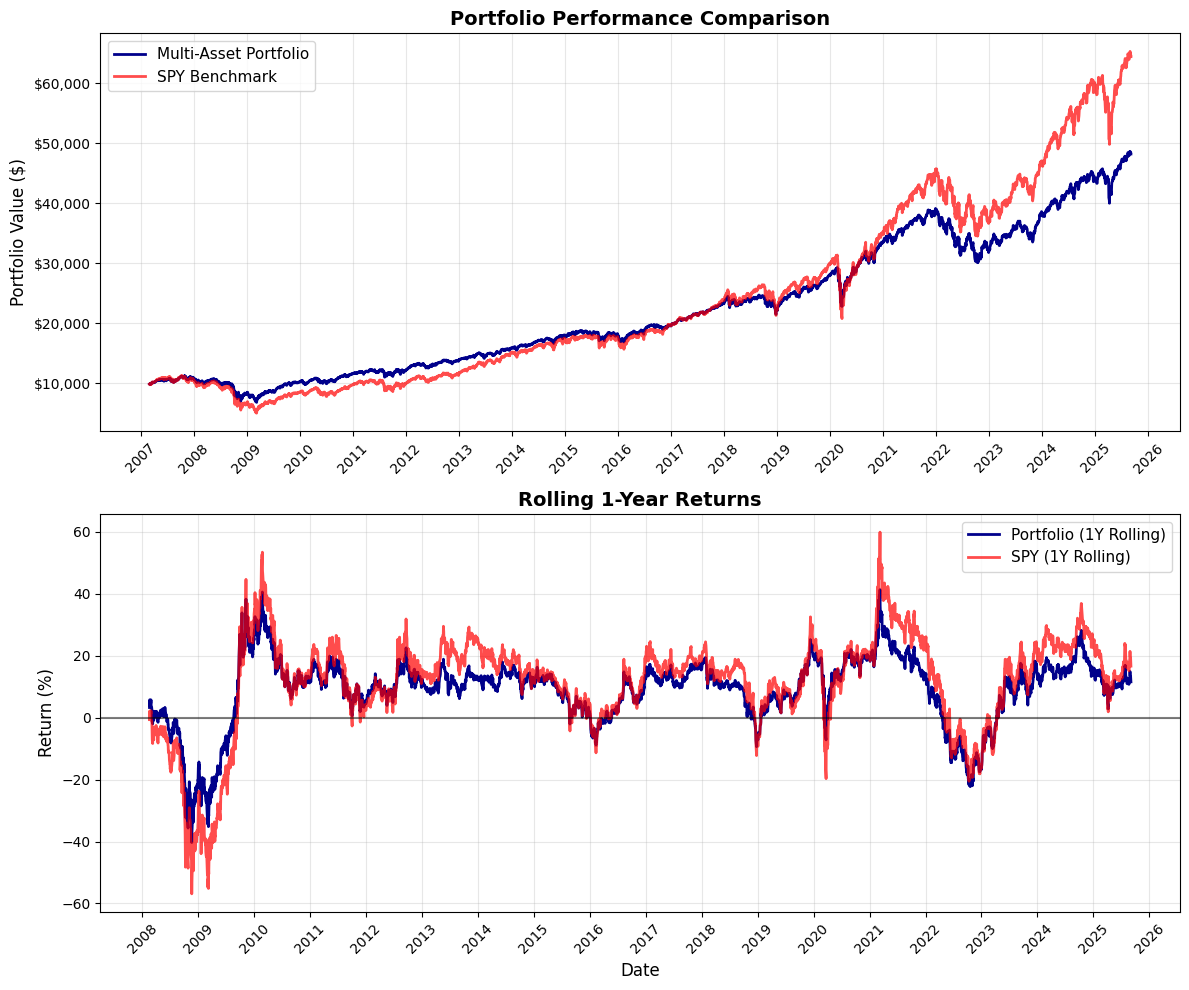


Final Portfolio Metrics:
  Final Value: $48,226
  Total Gain: $38,226
  Best 1-Year Period: 41.35%
  Worst 1-Year Period: -40.31%


In [185]:
# Portfolio Performance Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create performance comparison chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top chart: Cumulative performance
ax1.plot(portfolio_value.index, portfolio_value, label='Multi-Asset Portfolio', linewidth=2, color='darkblue')
ax1.plot(spy_value.index, spy_value, label='SPY Benchmark', linewidth=2, color='red', alpha=0.7)
ax1.set_title('Portfolio Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Bottom chart: Rolling 1-year returns
portfolio_rolling_return = portfolio_returns.rolling(252).sum()
spy_rolling_return = spy_returns.rolling(252).sum()

ax2.plot(portfolio_rolling_return.index, portfolio_rolling_return * 100, 
         label='Portfolio (1Y Rolling)', linewidth=2, color='darkblue')
ax2.plot(spy_rolling_return.index, spy_rolling_return * 100, 
         label='SPY (1Y Rolling)', linewidth=2, color='red', alpha=0.7)
ax2.set_title('Rolling 1-Year Returns', fontsize=14, fontweight='bold')
ax2.set_ylabel('Return (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Format x-axis
for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Performance statistics summary
print(f"\nFinal Portfolio Metrics:")
print(f"  Final Value: ${portfolio_value.iloc[-1]:,.0f}")
print(f"  Total Gain: ${portfolio_value.iloc[-1] - initial_investment:,.0f}")
print(f"  Best 1-Year Period: {portfolio_rolling_return.max():.2%}")
print(f"  Worst 1-Year Period: {portfolio_rolling_return.min():.2%}")

### Conclusion: ETL Pipeline Value Demonstration

This portfolio analysis demonstrates the **practical value** of our comprehensive ETL pipeline. Key capabilities enabled:

- **Clean data**: No calculation errors because all the dates line up perfectly
- **Multi-asset analysis**: Can compare different types of investments reliably  
- **Performance tracking**: Accurate returns calculation and benchmark comparison
- **Realistic results**: The data relationships make sense and look believable

Building and analyzing this **diversified portfolio** demonstrates how good data infrastructure enables financial analysis - from basic allocation decisions to performance measurement and comparison.